# Set up

## install

In [ ]:
!nvidia-smi

In [ ]:
# Get total number of logical (including hyperthreading) CPU cores
logical_cores = os.cpu_count()
print(f"Logical CPU Cores: {logical_cores}")

# Get number of physical cores (without hyperthreading)
physical_cores = psutil.cpu_count(logical=False)
print(f"Physical CPU Cores: {physical_cores}")

In [ ]:
# Get system memory details
mem = psutil.virtual_memory()

# Total RAM
print(f"Total RAM: {mem.total / (1024**3):.2f} GB")

# Available RAM
print(f"Available RAM: {mem.available / (1024**3):.2f} GB")

# Used RAM
print(f"Used RAM: {mem.used / (1024**3):.2f} GB")

# RAM Usage Percentage
print(f"RAM Usage: {mem.percent}%")

In [ ]:
# Get CPU usage per core
cpu_usage_per_core = psutil.cpu_percent(percpu=True)
print(f"CPU Usage per core: {cpu_usage_per_core}")

# Get overall CPU usage
cpu_usage = psutil.cpu_percent()
print(f"Overall CPU Usage: {cpu_usage}%")

In [2]:
import os
import psutil
import math
import time
import yaml
import shutil
import zipfile
import random
import requests
import cv2
import itertools
import json
import copy
from IPython.display import display_html
from scipy.spatial import ConvexHull
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
import folium
import matplotlib 
import mapclassify
import seaborn as sns

from collections import Counter
#from streetview import search_panoramas, get_panorama_meta, get_streetview, get_panorama_async, get_panorama

In [3]:
from shapely.geometry import MultiLineString
from shapely.ops import linemerge, unary_union
from shapely.geometry import Point

In [4]:
import torch  # For PyTorch
print(torch.cuda.is_available())  # True means a GPU is accessible

import ultralytics
from ultralytics import YOLO
from ultralytics import settings
ultralytics.checks()

Ultralytics 8.3.79 🚀 Python-3.12.9 torch-2.5.1 CUDA:0 (NVIDIA RTX A6000, 48670MiB)
Setup complete ✅ (72 CPUs, 187.8 GB RAM, 391.4/590.0 GB disk)


In [5]:
import subprocess

def install_opencv_headless():
    try:
        subprocess.run(["pip", "install", "opencv-python-headless"], check=True)
        print("opencv-python-headless installed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")

install_opencv_headless()

opencv-python-headless installed successfully.


## ultralytics settings

In [6]:
# refer to the following page
# https://docs.ultralytics.com/quickstart/#modifying-settings

In [7]:
!pwd

/home/jlee4338/storage/stpk/code


In [8]:
base_dir = "/home/jlee4338/storage/stpk"
base_dir

'/home/jlee4338/storage/stpk'

In [9]:
# refer to the following page
# https://docs.ultralytics.com/quickstart/#modifying-settings

# Update a setting+
settings.update({"datasets_dir": os.path.join(base_dir, "data")})
settings.update({"weights_dir": os.path.join(base_dir, "model/weights")})
settings.update({"runs_dir": os.path.join(base_dir, "model/runs")})
print(settings)

# Reset settings to default values
# settings.reset()

JSONDict("/home/jlee4338/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/home/jlee4338/storage/stpk/data",
  "weights_dir": "/home/jlee4338/storage/stpk/model/weights",
  "runs_dir": "/home/jlee4338/storage/stpk/model/runs",
  "uuid": "365c8ba184e4cf83ec5d194a63ea7e3011ec97becf23dc4ce5b8bb2f139e2856",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}


# Import 

## directory

In [10]:
!pwd

/home/jlee4338/storage/stpk/code


In [11]:
!ls ..

code  data  infer  model  seg


### cluster bbox

In [226]:
base_dir = "../seg"
cluster_bbox_lengthall = os.path.join(base_dir, "cluster_bbox_lengthall.geojson")
cluster_bbox_lengthall = gpd.read_file(cluster_bbox_lengthall)
cluster_bbox_lengthall["cluster"] = cluster_bbox_lengthall["cluster.x"] 
cluster_bbox_lengthall = cluster_bbox_lengthall.drop(columns=["cluster.x"])
print(cluster_bbox_lengthall.shape)
cluster_bbox_lengthall.iloc[0:3]

(24, 2)


,geometry,cluster
0,"POLYGON ((-84.45007 33.65942, -84.45007 33.686...",1
1,"POLYGON ((-84.42505 33.7356, -84.42505 33.7979...",2
2,"POLYGON ((-84.54317 33.6557, -84.54317 33.6659...",3


## road segments

In [12]:
base_dir = "../seg"
atl_roadsegs = os.path.join(base_dir, "atl_roadsegs.geojson")
atl_roadsegs = gpd.read_file(atl_roadsegs)
print(atl_roadsegs.shape)
atl_roadsegs.iloc[0:3]

seg_exclude = ["tertiary_18_1", "tertiary_26_2", "tertiary_53_5", "tertiary_35_4", "secondary_20_10"]
seg_exclude = ["cluster2_" + seg for seg in seg_exclude]
seg_exclude

atl_roadsegs = atl_roadsegs[~atl_roadsegs["link_id"].isin(seg_exclude)]
print(atl_roadsegs.shape)
atl_roadsegs.iloc[0:3]

atl_roadsegs["oneway"] = atl_roadsegs["oneway"].astype(str)
atl_roadsegs.loc[atl_roadsegs["oneway"] == "None", "oneway"] = "no"
atl_roadsegs = atl_roadsegs.rename(columns={'highway': 'road_type'})
orders = ["trunk", "primary", "secondary", "tertiary"]
atl_roadsegs["road_type"] = pd.Categorical(atl_roadsegs["road_type"], categories=orders, ordered=True)
orders = ["yes", "no"]
atl_roadsegs["oneway"] = pd.Categorical(atl_roadsegs["oneway"], categories=orders, ordered=True)
atl_roadsegs[0:5]

(1436, 7)
(1431, 7)


,name,road_type,road_id,link_id,length_m,oneway,geometry
0,Church Street,primary,primary_1,cluster1_primary_1_1,165.111029,no,"LINESTRING (-84.44057 33.68443, -84.44079 33.6..."
1,East Point Street,primary,primary_2,cluster1_primary_2_1,140.643969,no,"LINESTRING (-84.4425 33.67703, -84.44258 33.67..."
2,East Point Street,primary,primary_2,cluster1_primary_2_2,120.552538,no,"LINESTRING (-84.4422 33.67809, -84.44222 33.67..."
3,East Point Street,primary,primary_2,cluster1_primary_2_3,74.865051,no,"LINESTRING (-84.44202 33.67875, -84.44205 33.6..."
4,East Point Street,primary,primary_2,cluster1_primary_2_4,51.859353,no,"LINESTRING (-84.44189 33.6792, -84.44196 33.67..."


## sample points (pano_ids)

In [13]:
base_dir = "../seg"
input_path = os.path.join(base_dir, "atl_roadsegs_points_pano_combined_azi_long.geojson")
atl_roadsegs_points_pano_combined_azi_long = gpd.read_file(input_path).to_crs(4326)
print(atl_roadsegs_points_pano_combined_azi_long.shape)
atl_roadsegs_points_pano_combined_azi_long.iloc[0:3]

(45178, 15)


,link_id,point_id,oneway,azimuth_side,azimuth_toget,lng,lat,pano_id,date,pano_location,pano_lat,pano_lng,most_frequent_date,azimuth,geometry
0,cluster10_primary_1_2,0,no,left,-10.789815,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",33.692924,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293)
1,cluster10_primary_1_2,0,no,right,169.210185,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",33.692924,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293)
2,cluster10_primary_1_2,2,no,left,-10.774578,-84.517409,33.692891,Ocrf692xG3cLPnUWMit4jA,2024-06,"{ ""lat"": 33.692864385292999, ""lng"": -84.517368...",33.692864,-84.517369,2024-06,124.225422,POINT (-84.51741 33.69289)


# Apply on original imgs

## load images

In [177]:
base_dir = "../data"
folder_path = os.path.join(base_dir, "img_atl_0226")
print(folder_path)
print()
filenames = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) & f.endswith((".jpg"))]
filenames = sorted(filenames)
filenames = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) & f.endswith((".jpg"))]
print(len(filenames))
filenames = filenames
print(len(filenames))
filenames[0:3]

../data/img_atl_0226

30000
30000


['../data/img_atl_0226/gsv__cluster19_tertiary_3_14__right__11__401.585__2022-12__33.87214752,-84.341837838.jpg',
 '../data/img_atl_0226/gsv__cluster1_tertiary_6_7__left__59__163.615__2018-10__33.672231036,-84.436211203.jpg',
 '../data/img_atl_0226/gsv__cluster2_secondary_32_9__left__3__48.548__2024-07__33.784154492,-84.382273873.jpg']

## load model_nc_5_0209_l_30_nycatl

In [178]:
!ls ../model

model_nc_5_0209_l_30_nycatl  model_nc_5_0209_l_30_nyc.zip


In [179]:
base_dir = "../model"
input_path = os.path.join(base_dir, "model_nc_5_0209_l_30_nycatl", "weights/best.pt")
model_trained = YOLO(input_path)
type(model_trained)

ultralytics.models.yolo.model.YOLO

## infer

In [180]:
base_dir = '../infer'
output_path = os.path.join(base_dir, "inferred_model_nc_5_0209_l_30_nycatl")

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

In [181]:
# Function to create multiple ranges with increasing intervals
def generate_ranges(start, stop, interval, num_ranges):
    ranges = []
    for i in range(num_ranges):
        ranges.append(range(start + i * interval, start + (i + 1) * interval))
    return ranges

ranges = generate_ranges(0, 100, 100, 300)
print(ranges[0]) 
print(ranges[1]) 
print("...")
print(ranges[-2]) 
print(ranges[-1]) 

range(0, 100)
range(100, 200)
...
range(29800, 29900)
range(29900, 30000)


In [182]:
classes =  {
    "class_id": [0, 1, 2, 3, 4],
    "class_nm": ["prohibAnyT", "prohibSomeT", "prohibBusStop", "prohibCleaning", "allow"]}
classes = pd.DataFrame(classes)
classes

,class_id,class_nm
0,0,prohibAnyT
1,1,prohibSomeT
2,2,prohibBusStop
3,3,prohibCleaning
4,4,allow


In [183]:
classes.iloc[1]["class_nm"]

'prohibSomeT'

### for loop

In [23]:
log_detected = []
command = ["nvidia-smi", "--query-gpu=memory.free", "--format=csv,nounits"]
THRES_CONFID = 0.1
THRES_AREA = 200

os.makedirs(output_path, exist_ok=True)

for i, r in enumerate(ranges):
    print(f"{i}th range starts:{r}")
    batch_range = r
    files = filenames[batch_range[0]:batch_range[-1]]
    results = model_trained.predict(files, conf=THRES_CONFID, device="cuda:0", save=False, verbose=False, batch=4, half=True)

    for k, result in enumerate(results):
        boxes = result.boxes  # Boxes object for bounding box outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        keypoints = result.keypoints  # Keypoints object for pose outputs
        probs = result.probs  # Probs object for classification outputs
        obb = result.obb  # Oriented boxes object for OBB outputs
        boxes = result.boxes.data
        file = files[k].split("/")[-1]
        file = file.split(".j")[0]
        file = "__".join([file.split("__")[1], file.split("__")[2], file.split("__")[3]])
    
        for j, box in enumerate(boxes):
            xmin, ymin, xmax, ymax, confidence, class_id = box.tolist()  # Convert tensor to list
            xmin, ymin, xmax, ymax, confidence = int(xmin), int(ymin), int(xmax), int(ymax), round(confidence, 2)  # Convert to integers
            area = (xmax-xmin) * (ymax-ymin)
            class_id = int(class_id)
    
            # Crop the ROI
            if confidence > THRES_CONFID and area > THRES_AREA:
                filename = f"{file}__{j}__{class_id}__{confidence}__{area}.jpg"
                result.save(filename= os.path.join(output_path, filename))  # save to disk
                
                log_detected.append({
                    "file_id": file,
                    "detection_index": j,
                    "class_id": class_id,
                    "xmin": xmin,
                    "ymin": ymin,
                    "xmax": xmax,
                    "ymax": ymax,
                    "confidence": confidence,
                    "area": area,
                    "saved_filename": filename
                })

    log_detected_df = pd.DataFrame(log_detected)
    log_detected_df = log_detected_df.merge(classes, on="class_id", how="left")

    # delete the results for the current range
    del results
    torch.cuda.empty_cache()

    # Command to query GPU free memory
    # Execute the command and capture the output
    shell_op = subprocess.run(command, stdout=subprocess.PIPE, text=True)

    # Print the output
    print(shell_op.stdout)

0th range starts:range(0, 100)
memory.free [MiB]
48199
48666
48658
48666

1th range starts:range(100, 200)
memory.free [MiB]
48199
48666
48658
48666

2th range starts:range(200, 300)


KeyboardInterrupt: 

### parallel

In [184]:
from concurrent.futures import ThreadPoolExecutor
import torch.multiprocessing as mp

In [185]:
# Constants
THRES_CONFID = 0.1
THRES_AREA = 200
command = ["nvidia-smi", "--query-gpu=memory.free", "--format=csv,nounits"]
base_dir = "../model"
input_path = os.path.join(base_dir, "model_nc_5_0209_l_30_nycatl", "weights/best.pt")

# Ensure CUDA multiprocessing works
if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)
    
    # Function to process a single batch
    def process_batch(i, batch_range, filenames):
        print(f"{i}th range starts: {batch_range}")

        # load files for a batch
        files = filenames[batch_range[0]:batch_range[-1]]

        # load model each time
        model_trained = YOLO(input_path)

        # infer
        results = model_trained.predict(files, conf=THRES_CONFID, device="cuda:0", save=False, verbose=False, batch=4, half=True)
    
        batch_log = []
        for k, result in enumerate(results):
            boxes = result.boxes.data
            file = files[k].split("/")[-1].split(".j")[0]
            # link_id, side, point_id, azimuth
            file = "__".join([file.split("__")[1], file.split("__")[2], file.split("__")[3]])
            
            for j, box in enumerate(boxes):
                xmin, ymin, xmax, ymax, confidence, class_id = box.tolist()
                xmin, ymin, xmax, ymax, confidence = int(xmin), int(ymin), int(xmax), int(ymax), round(confidence, 2)
                area = (xmax - xmin) * (ymax - ymin)
                class_id = int(class_id)
                class_nm = classes.iloc[class_id]["class_nm"]
    
                if confidence > THRES_CONFID and area > THRES_AREA:
                    filename = f"{file}__{j}__{class_nm}__{confidence}__{area}.jpg"
                    result.save(filename=os.path.join(output_path, filename))
                    
                    batch_log.append({
                        "file_id": file,
                        "detection_index": j,
                        "class_id": class_id,
                        "class_nm": class_nm,
                        "xmin": xmin,
                        "ymin": ymin,
                        "xmax": xmax,
                        "ymax": ymax,
                        "confidence": confidence,
                        "area": area,
                        "saved_filename": filename
                    })

        print(len(batch_log))
        torch.cuda.empty_cache()  # Free GPU memory
    
        # Query GPU memory
        shell_op = subprocess.run(command, stdout=subprocess.PIPE, text=True)
        #print(shell_op.stdout)
    
        return batch_log
    
    # Run in parallel
    log_detected = []
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust workers based on GPU capacity
        futures = {executor.submit(process_batch, i, r, filenames): i for i, r in enumerate(ranges)}
        
        for future in futures:
            try:
                log_detected.extend(future.result())  # Collect results
            except Exception as e:
                print(f"Error processing batch {futures[future]}: {e}")
    
    # Convert to DataFrame and merge with classes
    log_detected_df = pd.DataFrame(log_detected)
    
    print("Processing complete!")

0th range starts: range(0, 100)
1th range starts: range(100, 200)
2th range starts: range(200, 300)
3th range starts: range(300, 400)
7
4
4
4
4th range starts: range(400, 500)
5th range starts: range(500, 600)
6th range starts: range(600, 700)
7th range starts: range(700, 800)
3
8th range starts: range(800, 900)
6
9th range starts: range(900, 1000)
3
10th range starts: range(1000, 1100)
9
11th range starts: range(1100, 1200)
2
3
12th range starts: range(1200, 1300)
13th range starts: range(1300, 1400)
2
4
14th range starts: range(1400, 1500)
15th range starts: range(1500, 1600)
4
7
16th range starts: range(1600, 1700)
17th range starts: range(1700, 1800)
6
7
18th range starts: range(1800, 1900)
19th range starts: range(1900, 2000)
5
20th range starts: range(2000, 2100)
7
4
21th range starts: range(2100, 2200)
7
22th range starts: range(2200, 2300)
23th range starts: range(2300, 2400)
4
6
6
6
24th range starts: range(2400, 2500)
25th range starts: range(2500, 2600)
26th range starts: ra

# Log data

In [187]:
base_dir = '../infer'
output_path = os.path.join(base_dir, "inferred_model_nc_5_0209_l_30_nycatl.csv")
log_detected_df.to_csv(output_path, index=False)

In [188]:
log_detected_df.columns

Index(['file_id', 'detection_index', 'class_id', 'class_nm', 'xmin', 'ymin',
       'xmax', 'ymax', 'confidence', 'area', 'saved_filename'],
      dtype='object')

In [189]:
log_detected_df = log_detected_df[['file_id', 'class_nm', 'confidence', 'area',
                                       'detection_index', 'class_id', 
                                       'xmin', 'ymin', 'xmax', 'ymax', 'saved_filename']]
log_detected_df

,file_id,class_nm,confidence,area,detection_index,class_id,xmin,ymin,xmax,ymax,saved_filename
0,cluster2_secondary_32_1__right__13,prohibAnyT,0.41,697,0,0,335,287,352,328,cluster2_secondary_32_1__right__13__0__prohibA...
1,cluster2_secondary_32_1__right__13,prohibSomeT,0.38,697,1,1,335,287,352,328,cluster2_secondary_32_1__right__13__1__prohibS...
2,cluster2_secondary_15_2__left__52,prohibSomeT,0.30,434,0,1,626,272,640,303,cluster2_secondary_15_2__left__52__0__prohibSo...
3,cluster2_secondary_15_6__right__24,prohibAnyT,0.11,204,0,0,337,308,349,325,cluster2_secondary_15_6__right__24__0__prohibA...
4,cluster2_tertiary_46_4__right__28,prohibAnyT,0.19,714,0,0,419,296,436,338,cluster2_tertiary_46_4__right__28__0__prohibAn...
...,...,...,...,...,...,...,...,...,...,...,...
1419,cluster2_tertiary_11_1__right__67,prohibAnyT,0.56,390,0,0,106,256,121,282,cluster2_tertiary_11_1__right__67__0__prohibAn...
1420,cluster2_secondary_34_8__left__21,prohibBusStop,0.40,675,0,2,515,306,542,331,cluster2_secondary_34_8__left__21__0__prohibBu...
1421,cluster2_tertiary_14_2__left__31,prohibAnyT,0.14,240,0,0,205,309,220,325,cluster2_tertiary_14_2__left__31__0__prohibAny...
1422,cluster2_tertiary_17_8__right__1,prohibAnyT,0.29,209,0,0,297,310,308,329,cluster2_tertiary_17_8__right__1__0__prohibAny...


In [191]:
log_detected_df["cluster_id"] = log_detected_df["file_id"].apply(lambda x: x.split("__")[0].split("_")[0])
log_detected_df["road_type"] = log_detected_df["file_id"].apply(lambda x: x.split("__")[0].split("_")[1])
log_detected_df["link_id"] = log_detected_df["file_id"].apply(lambda x: x.split("__")[0])
log_detected_df["side"] = log_detected_df["file_id"].apply(lambda x: x.split("__")[1])
log_detected_df["point_id"] = log_detected_df["file_id"].apply(lambda x: int(x.split("__")[2]))

log_detected_df = log_detected_df[['cluster_id', 'road_type', 'link_id', 'side', 'point_id', 
                                   'class_nm', 'confidence', 'area',
                                   'detection_index', 'class_id',
                                   'xmin', 'ymin', 'xmax', 'ymax', 'file_id', 'saved_filename']]
log_detected_df = log_detected_df.sort_values(by=['cluster_id', 'road_type', 'link_id', 'side', 'point_id'])
log_detected_df

,cluster_id,road_type,link_id,side,point_id,class_nm,confidence,area,detection_index,class_id,xmin,ymin,xmax,ymax,file_id,saved_filename
1268,cluster1,primary,cluster1_primary_2_5,right,19,prohibAnyT,0.44,234,0,0,489,291,498,317,cluster1_primary_2_5__right__19,cluster1_primary_2_5__right__19__0__prohibAnyT...
1202,cluster1,primary,cluster1_primary_3_1,right,7,allow,0.20,240,0,4,363,295,375,315,cluster1_primary_3_1__right__7,cluster1_primary_3_1__right__7__0__allow__0.2_...
729,cluster1,primary,cluster1_primary_4_14,left,6,prohibAnyT,0.83,560,0,0,390,300,410,328,cluster1_primary_4_14__left__6,cluster1_primary_4_14__left__6__0__prohibAnyT_...
1237,cluster1,primary,cluster1_primary_4_14,left,26,prohibAnyT,0.32,261,0,0,547,248,556,277,cluster1_primary_4_14__left__26,cluster1_primary_4_14__left__26__0__prohibAnyT...
206,cluster1,primary,cluster1_primary_4_14,left,36,prohibAnyT,0.54,405,0,0,352,287,367,314,cluster1_primary_4_14__left__36,cluster1_primary_4_14__left__36__0__prohibAnyT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,cluster23,trunk,cluster23_trunk_1_1,right,21,prohibSomeT,0.34,342,0,1,239,330,257,349,cluster23_trunk_1_1__right__21,cluster23_trunk_1_1__right__21__0__prohibSomeT...
1195,cluster23,trunk,cluster23_trunk_1_1,right,23,prohibAnyT,0.54,414,0,0,350,329,368,352,cluster23_trunk_1_1__right__23,cluster23_trunk_1_1__right__23__0__prohibAnyT_...
1196,cluster23,trunk,cluster23_trunk_1_1,right,23,prohibSomeT,0.45,396,1,1,350,329,368,351,cluster23_trunk_1_1__right__23,cluster23_trunk_1_1__right__23__1__prohibSomeT...
90,cluster24,secondary,cluster24_secondary_1_2,left,69,prohibAnyT,0.29,378,0,0,553,272,571,293,cluster24_secondary_1_2__left__69,cluster24_secondary_1_2__left__69__0__prohibAn...


In [192]:
log_detected_df_slim = log_detected_df[['file_id', 
                                       'class_nm', 'confidence', 'area',
                                       'detection_index', 'class_id']]

# Descriptive stat

## by cluster

In [274]:
log_detected_df_stat = log_detected_df.groupby(["cluster_id", "class_nm"]).count().reset_index()[["cluster_id", "class_nm", "point_id"]]
log_detected_df_stat["count"] = log_detected_df_stat["point_id"].astype(int)
log_detected_df_stat = log_detected_df_stat.drop(columns=["point_id"])

log_detected_df_stat["cluster_id"] = log_detected_df_stat["cluster_id"].str.slice(7, )
log_detected_df_stat["cluster_id"] = log_detected_df_stat["cluster_id"].astype(int)
log_detected_df_stat = log_detected_df_stat.sort_values(by=["cluster_id", "class_nm"])

log_detected_df_stat = log_detected_df_stat.pivot(index="cluster_id", columns="class_nm", values="count")
log_detected_df_stat.fillna(0, inplace=True)
log_detected_df_stat = log_detected_df_stat.astype({col: int for col in log_detected_df_stat.select_dtypes(include="float").columns})

#log_detected_df_stat["Total"] = log_detected_df_stat.sum(axis=1)
#log_detected_df_stat.loc["Total"] = log_detected_df_stat.sum()
log_detected_df_stat

class_nm,allow,prohibAnyT,prohibBusStop,prohibCleaning,prohibSomeT
cluster_id,,,,,
1,7,71,11,5,4
2,288,613,59,20,107
10,0,4,0,1,1
11,1,3,2,0,1
12,0,1,0,0,0
13,1,10,2,1,2
14,5,18,2,0,5
15,3,5,0,0,2
16,18,25,2,0,2


In [275]:
df = log_detected_df_stat

# Compute row-wise proportions
df_proportions = df.iloc[:, 0:].div(df.iloc[:, 0:].sum(axis=1), axis=0).round(2)

# Format counts with proportions in parentheses
for col in df_proportions.columns:
    df[col] = df[col].astype(str) + " (" + df_proportions[col].mul(100).round(0).astype(int).astype(str) + "%)"
df

class_nm,allow,prohibAnyT,prohibBusStop,prohibCleaning,prohibSomeT
cluster_id,,,,,
1,7 (7%),71 (72%),11 (11%),5 (5%),4 (4%)
2,288 (26%),613 (56%),59 (5%),20 (2%),107 (10%)
10,0 (0%),4 (67%),0 (0%),1 (17%),1 (17%)
11,1 (14%),3 (43%),2 (29%),0 (0%),1 (14%)
12,0 (0%),1 (100%),0 (0%),0 (0%),0 (0%)
13,1 (6%),10 (62%),2 (12%),1 (6%),2 (12%)
14,5 (17%),18 (60%),2 (7%),0 (0%),5 (17%)
15,3 (30%),5 (50%),0 (0%),0 (0%),2 (20%)
16,18 (38%),25 (53%),2 (4%),0 (0%),2 (4%)


## by road type

In [271]:
log_detected_df_stat = log_detected_df.groupby(["road_type", "class_nm"]).count().reset_index()[["road_type", "class_nm", "point_id"]]
log_detected_df_stat["count"] = log_detected_df_stat["point_id"].astype(int)
log_detected_df_stat = log_detected_df_stat.drop(columns=["point_id"])

log_detected_df_stat = log_detected_df_stat.sort_values(by=["road_type", "class_nm"])
log_detected_df_stat = log_detected_df_stat.pivot(index="road_type", columns="class_nm", values="count")
log_detected_df_stat.fillna(0, inplace=True)
log_detected_df_stat = log_detected_df_stat.astype({col: int for col in log_detected_df_stat.select_dtypes(include="float").columns})
#log_detected_df_stat["Total"] = log_detected_df_stat.sum(axis=1)
#log_detected_df_stat.loc["Total"] = log_detected_df_stat.sum()
log_detected_df_stat

class_nm,allow,prohibAnyT,prohibBusStop,prohibCleaning,prohibSomeT
road_type,,,,,
primary,13,88,5,5,7
secondary,193,410,54,16,78
tertiary,128,317,25,11,55
trunk,4,8,4,0,3


In [273]:
df = log_detected_df_stat

# Compute row-wise proportions
df_proportions = df.iloc[:, 0:].div(df.iloc[:, 0:].sum(axis=1), axis=0).round(2)

# Format counts with proportions in parentheses
for col in df_proportions.columns:
    df[col] = df[col].astype(str) + " (" + df_proportions[col].mul(100).round(0).astype(int).astype(str) + "%)"
df

class_nm,allow,prohibAnyT,prohibBusStop,prohibCleaning,prohibSomeT
road_type,,,,,
primary,13 (11%),88 (75%),5 (4%),5 (4%),7 (6%)
secondary,193 (26%),410 (55%),54 (7%),16 (2%),78 (10%)
tertiary,128 (24%),317 (59%),25 (5%),11 (2%),55 (10%)
trunk,4 (21%),8 (42%),4 (21%),0 (0%),3 (16%)


## performance metrics

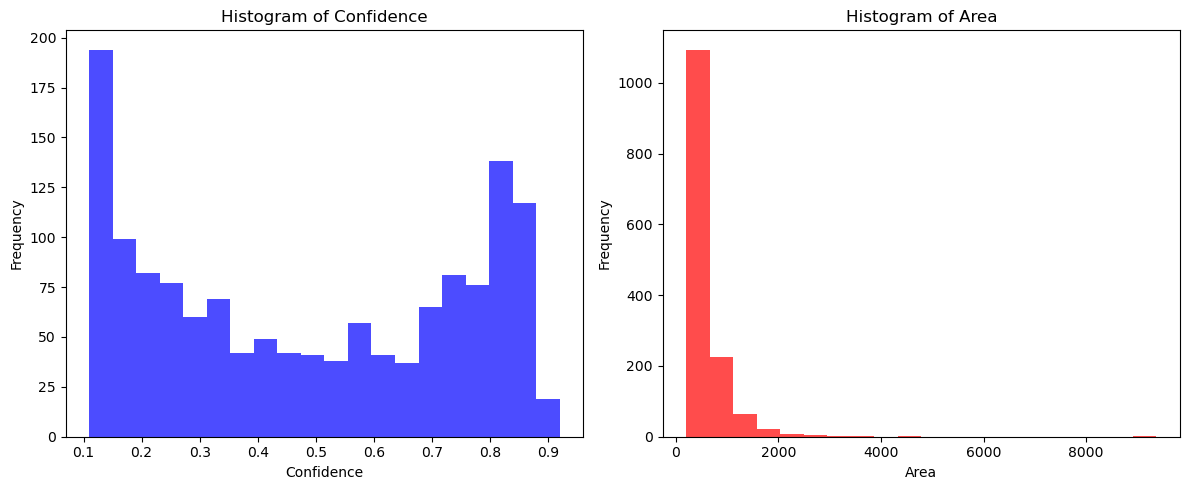

In [326]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for Confidence
axes[0].hist(log_detected_df["confidence"], bins=20, color="blue", alpha=0.7)
axes[0].set_title("Histogram of Confidence")
axes[0].set_xlabel("Confidence")
axes[0].set_ylabel("Frequency")

# Histogram for Area
axes[1].hist(log_detected_df["area"], bins=20, color="red", alpha=0.7)
axes[1].set_title("Histogram of Area")
axes[1].set_xlabel("Area")
axes[1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

/tmp/ipykernel_301365/3212442401.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/tmp/ipykernel_301365/3212442401.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


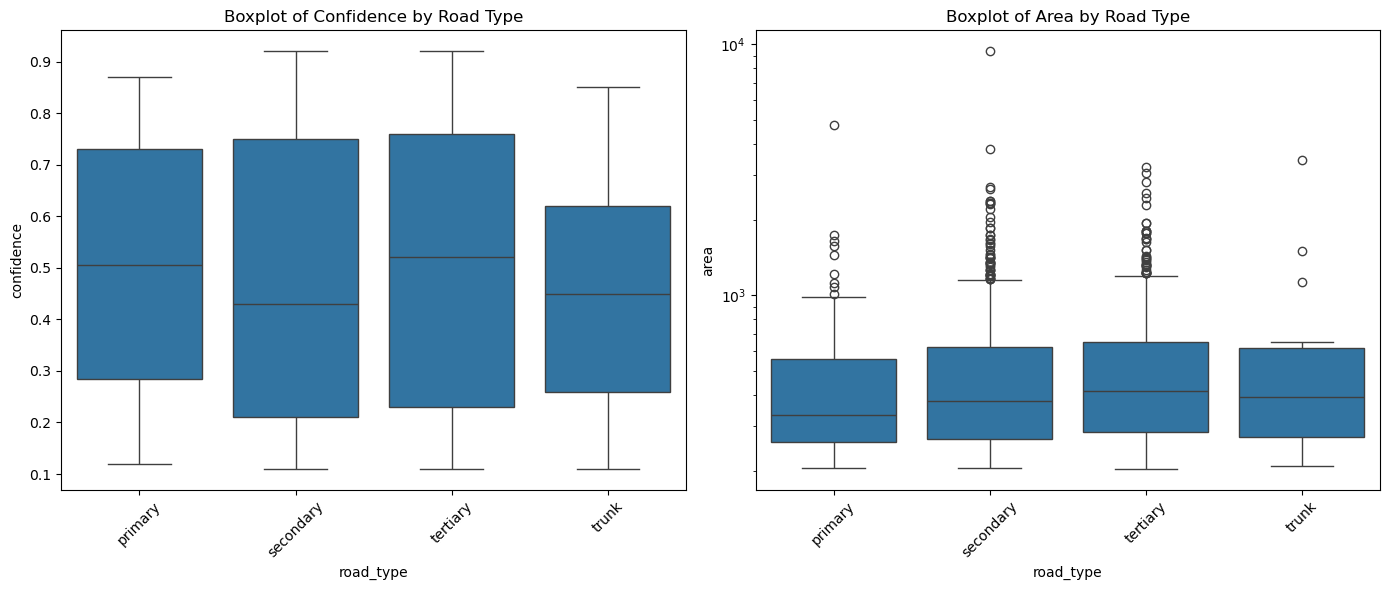

In [332]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figure size

# Boxplot for Confidence
sns.boxplot(data=log_detected_df, x="road_type", y="confidence", ax=axes[0])
axes[0].set_title("Boxplot of Confidence by Road Type")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Rotate x-axis labels

# Boxplot for Area (with log scale)
sns.boxplot(data=log_detected_df, x="road_type", y="area", ax=axes[1])
axes[1].set_title("Boxplot of Area by Road Type")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_yscale("log")  # Apply log scale

# Adjust layout for clarity
plt.tight_layout()

# Show plot
plt.show()

In [333]:
log_detected_df

,cluster_id,road_type,link_id,side,point_id,class_nm,confidence,area,detection_index,class_id,xmin,ymin,xmax,ymax,file_id,saved_filename
1268,cluster1,primary,cluster1_primary_2_5,right,19,prohibAnyT,0.44,234,0,0,489,291,498,317,cluster1_primary_2_5__right__19,cluster1_primary_2_5__right__19__0__prohibAnyT...
1202,cluster1,primary,cluster1_primary_3_1,right,7,allow,0.20,240,0,4,363,295,375,315,cluster1_primary_3_1__right__7,cluster1_primary_3_1__right__7__0__allow__0.2_...
729,cluster1,primary,cluster1_primary_4_14,left,6,prohibAnyT,0.83,560,0,0,390,300,410,328,cluster1_primary_4_14__left__6,cluster1_primary_4_14__left__6__0__prohibAnyT_...
1237,cluster1,primary,cluster1_primary_4_14,left,26,prohibAnyT,0.32,261,0,0,547,248,556,277,cluster1_primary_4_14__left__26,cluster1_primary_4_14__left__26__0__prohibAnyT...
206,cluster1,primary,cluster1_primary_4_14,left,36,prohibAnyT,0.54,405,0,0,352,287,367,314,cluster1_primary_4_14__left__36,cluster1_primary_4_14__left__36__0__prohibAnyT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,cluster23,trunk,cluster23_trunk_1_1,right,21,prohibSomeT,0.34,342,0,1,239,330,257,349,cluster23_trunk_1_1__right__21,cluster23_trunk_1_1__right__21__0__prohibSomeT...
1195,cluster23,trunk,cluster23_trunk_1_1,right,23,prohibAnyT,0.54,414,0,0,350,329,368,352,cluster23_trunk_1_1__right__23,cluster23_trunk_1_1__right__23__0__prohibAnyT_...
1196,cluster23,trunk,cluster23_trunk_1_1,right,23,prohibSomeT,0.45,396,1,1,350,329,368,351,cluster23_trunk_1_1__right__23,cluster23_trunk_1_1__right__23__1__prohibSomeT...
90,cluster24,secondary,cluster24_secondary_1_2,left,69,prohibAnyT,0.29,378,0,0,553,272,571,293,cluster24_secondary_1_2__left__69,cluster24_secondary_1_2__left__69__0__prohibAn...


/tmp/ipykernel_301365/1939140120.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Rotate x-axis labels
/tmp/ipykernel_301365/1939140120.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


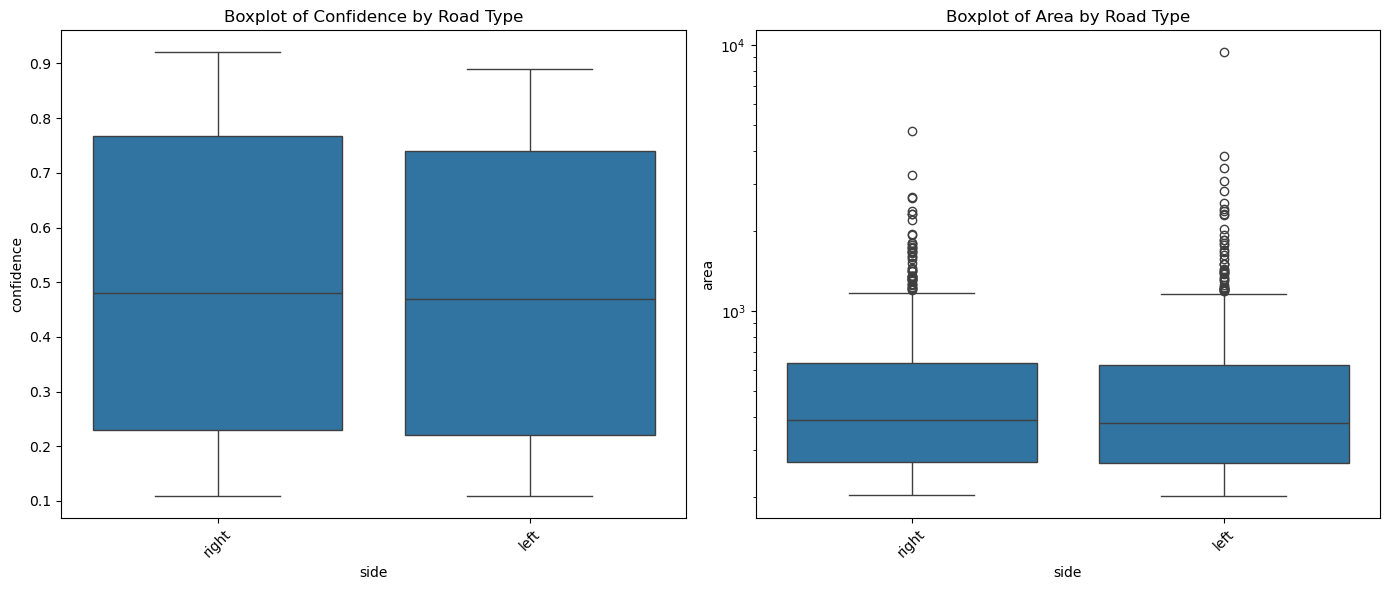

In [335]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figure size

# Boxplot for Confidence
sns.boxplot(data=log_detected_df, x="side", y="confidence", ax=axes[0])
axes[0].set_title("Boxplot of Confidence by Road Type")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Rotate x-axis labels

# Boxplot for Area (with log scale)
sns.boxplot(data=log_detected_df, x="side", y="area", ax=axes[1])
axes[1].set_title("Boxplot of Area by Road Type")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_yscale("log")  # Apply log scale

# Adjust layout for clarity
plt.tight_layout()

# Show plot
plt.show()

# Sensitivity analysis

## by confidence level

In [296]:
CONFIDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
log_detected_df_stat = dict()

for i, CONFID in enumerate(CONFIDS):
    temp = log_detected_df[log_detected_df["confidence"] > CONFID]
    temp = temp.groupby(["class_nm"])["class_nm"].count()
    log_detected_df_stat[CONFID] = temp.to_dict()
log_detected_df_stat = pd.DataFrame(log_detected_df_stat)
log_detected_df_stat.fillna(0, inplace=True)
log_detected_df_stat = log_detected_df_stat.astype({col: int for col in log_detected_df_stat.select_dtypes(include="float").columns})
log_detected_df_stat = log_detected_df_stat.reset_index()
log_detected_df_stat["class_nm"] = log_detected_df_stat["index"]
log_detected_df_stat = log_detected_df_stat.drop(columns=["index"])
log_detected_df_stat

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,class_nm
0,338,247,203,175,150,131,107,51,3,allow
1,823,692,604,524,457,384,318,178,0,prohibAnyT
2,88,56,46,34,24,19,10,3,0,prohibBusStop
3,32,21,14,8,6,3,1,1,0,prohibCleaning
4,143,95,61,49,37,28,14,6,0,prohibSomeT


In [297]:
log_detected_df_stat = log_detected_df_stat.melt(id_vars=["class_nm"], var_name="confidence_level", value_name="count")
log_detected_df_stat

,class_nm,confidence_level,count
0,allow,0.1,338
1,prohibAnyT,0.1,823
2,prohibBusStop,0.1,88
3,prohibCleaning,0.1,32
4,prohibSomeT,0.1,143
5,allow,0.2,247
6,prohibAnyT,0.2,692
7,prohibBusStop,0.2,56
8,prohibCleaning,0.2,21
9,prohibSomeT,0.2,95


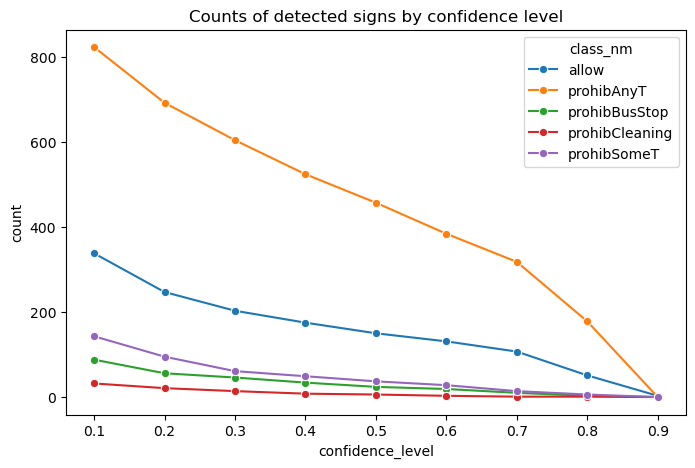

In [301]:
# Create multiple line plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=log_detected_df_stat, x="confidence_level", y="count", hue="class_nm", marker="o")

# Customize
plt.title("Counts of detected signs by confidence level")
plt.xlabel("confidence_level")
plt.ylabel("count")
#plt.xticks(log_detected_df_stat["confidence_level"].unique())
plt.legend(title="class_nm")
plt.show()

## by area

In [303]:
AREA = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
log_detected_df_stat = dict()

for i, AREA in enumerate(AREA):
    temp = log_detected_df[log_detected_df["area"] > AREA]
    temp = temp.groupby(["class_nm"])["class_nm"].count()
    log_detected_df_stat[AREA] = temp.to_dict()
log_detected_df_stat = pd.DataFrame(log_detected_df_stat)
log_detected_df_stat.fillna(0, inplace=True)
log_detected_df_stat = log_detected_df_stat.astype({col: int for col in log_detected_df_stat.select_dtypes(include="float").columns})
log_detected_df_stat = log_detected_df_stat.reset_index()
log_detected_df_stat["class_nm"] = log_detected_df_stat["index"]
log_detected_df_stat = log_detected_df_stat.drop(columns=["index"])
log_detected_df_stat

,200,400,600,800,1000,1200,1400,1600,1800,2000,class_nm
0,338,173,108,59,38,20,13,9,8,6,allow
1,823,354,193,106,71,41,29,19,8,5,prohibAnyT
2,88,52,35,20,14,11,7,6,6,5,prohibBusStop
3,32,18,10,3,3,2,2,2,2,2,prohibCleaning
4,143,74,40,25,20,13,5,4,3,1,prohibSomeT


In [304]:
log_detected_df_stat = log_detected_df_stat.melt(id_vars=["class_nm"], var_name="area", value_name="count")
log_detected_df_stat

,class_nm,area,count
0,allow,200,338
1,prohibAnyT,200,823
2,prohibBusStop,200,88
3,prohibCleaning,200,32
4,prohibSomeT,200,143
5,allow,400,173
6,prohibAnyT,400,354
7,prohibBusStop,400,52
8,prohibCleaning,400,18
9,prohibSomeT,400,74


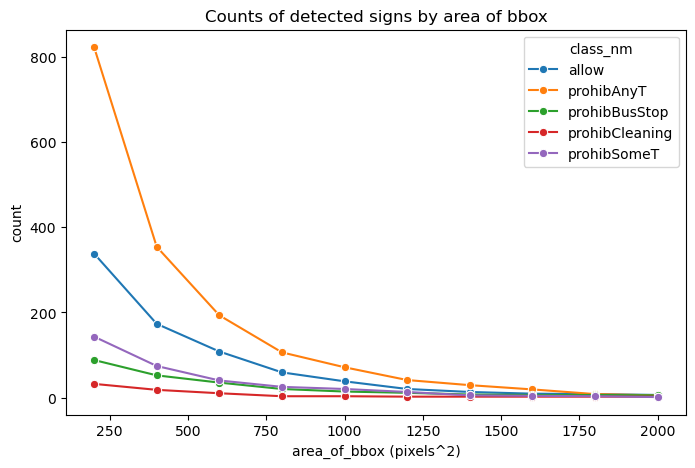

In [309]:
# Create multiple line plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=log_detected_df_stat, x="area", y="count", hue="class_nm", marker="o")

# Customize
plt.title("Counts of detected signs by area of bbox")
plt.xlabel("area_of_bbox (pixels^2)")
plt.ylabel("count")
#plt.xticks(log_detected_df_stat["confidence_level"].unique())
plt.legend(title="class_nm")
plt.show()

## issue

In [316]:
log_detected_df.groupby("road_type")[["confidence", "area"]].mean()
log_detected_df.groupby("road_type")[["confidence", "area"]].median()
log_detected_df.groupby("road_type")[["confidence", "area"]].min()
log_detected_df.groupby("road_type")[["confidence", "area"]].max()

,confidence,area
road_type,,
primary,0.87,4753
secondary,0.92,9373
tertiary,0.92,3250
trunk,0.85,3450


In [317]:
log_detected_df.groupby("road_type")[["confidence", "area"]].describe()

confidence                                                      \
               count      mean       std   min    25%    50%   75%   max   
road_type                                                                  
primary        118.0  0.502458  0.240167  0.12  0.285  0.505  0.73  0.87   
secondary      751.0  0.474328  0.268054  0.11  0.210  0.430  0.75  0.92   
tertiary       536.0  0.498563  0.265785  0.11  0.230  0.520  0.76  0.92   
trunk           19.0  0.444737  0.230467  0.11  0.260  0.450  0.62  0.85   

            area                                                               
           count        mean         std    min     25%    50%    75%     max  
road_type                                                                      
primary    118.0  500.627119  501.879558  204.0  260.00  331.5  558.0  4753.0  
secondary  751.0  524.051931  506.700605  204.0  266.00  377.0  619.5  9373.0  
tertiary   536.0  548.380597  410.051769  203.0  285.75  416.0  650.0  3250.0  
trunk       19.0  639.000000  756.053423  208.0  273.00  392.0  613.0  3450.0

In [ ]:
AREA = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
log_detected_df_stat = dict()

for i, AREA in enumerate(AREA):
    temp = log_detected_df[log_detected_df["area"] > AREA]
    temp = temp.groupby(["class_nm"])["class_nm"].count()
    log_detected_df_stat[AREA] = temp.to_dict()
log_detected_df_stat = pd.DataFrame(log_detected_df_stat)
log_detected_df_stat.fillna(0, inplace=True)
log_detected_df_stat = log_detected_df_stat.astype({col: int for col in log_detected_df_stat.select_dtypes(include="float").columns})
log_detected_df_stat = log_detected_df_stat.reset_index()
log_detected_df_stat["class_nm"] = log_detected_df_stat["index"]
log_detected_df_stat = log_detected_df_stat.drop(columns=["index"])
log_detected_df_stat

# Mapping

In [193]:
print(atl_roadsegs_points_pano_combined_azi_long.shape)
atl_roadsegs_points_pano_combined_azi_long.iloc[0:3]

(45178, 16)


,link_id,point_id,oneway,azimuth_side,azimuth_toget,lng,lat,pano_id,date,pano_location,pano_lat,pano_lng,most_frequent_date,azimuth,geometry,file_id
0,cluster10_primary_1_2,0,no,left,-10.789815,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",33.692924,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293),cluster10_primary_1_2__left__0
1,cluster10_primary_1_2,0,no,right,169.210185,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",33.692924,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293),cluster10_primary_1_2__right__0
2,cluster10_primary_1_2,2,no,left,-10.774578,-84.517409,33.692891,Ocrf692xG3cLPnUWMit4jA,2024-06,"{ ""lat"": 33.692864385292999, ""lng"": -84.517368...",33.692864,-84.517369,2024-06,124.225422,POINT (-84.51741 33.69289),cluster10_primary_1_2__left__2


In [194]:
atl_roadsegs_points_pano_combined_azi_long["file_id"] = atl_roadsegs_points_pano_combined_azi_long[
    ["link_id", "azimuth_side", "point_id"]
].astype(str).agg("__".join, axis=1)
atl_roadsegs_points_pano_combined_azi_long.iloc[0:3]

,link_id,point_id,oneway,azimuth_side,azimuth_toget,lng,lat,pano_id,date,pano_location,pano_lat,pano_lng,most_frequent_date,azimuth,geometry,file_id
0,cluster10_primary_1_2,0,no,left,-10.789815,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",33.692924,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293),cluster10_primary_1_2__left__0
1,cluster10_primary_1_2,0,no,right,169.210185,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",33.692924,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293),cluster10_primary_1_2__right__0
2,cluster10_primary_1_2,2,no,left,-10.774578,-84.517409,33.692891,Ocrf692xG3cLPnUWMit4jA,2024-06,"{ ""lat"": 33.692864385292999, ""lng"": -84.517368...",33.692864,-84.517369,2024-06,124.225422,POINT (-84.51741 33.69289),cluster10_primary_1_2__left__2


In [195]:
filenames = [f.split("/")[-1].split(".j")[0] for f in filenames]
filenames = ["__".join([f.split("__")[1], f.split("__")[2], f.split("__")[3]]) for f in filenames]
print(len(filenames))
filenames[0:5]

30000


['cluster19_tertiary_3_14__right__11',
 'cluster1_tertiary_6_7__left__59',
 'cluster2_secondary_32_9__left__3',
 'cluster2_secondary_24_2__left__16',
 'cluster2_secondary_28_9__right__10']

In [196]:
atl_roadsegs_points_pano_combined_azi_long_inferred = atl_roadsegs_points_pano_combined_azi_long[atl_roadsegs_points_pano_combined_azi_long["file_id"].isin(filenames)]
print(atl_roadsegs_points_pano_combined_azi_long_inferred.shape)
atl_roadsegs_points_pano_combined_azi_long_inferred.iloc[0:3]

(30000, 16)


,link_id,point_id,oneway,azimuth_side,azimuth_toget,lng,lat,pano_id,date,pano_location,pano_lat,pano_lng,most_frequent_date,azimuth,geometry,file_id
0,cluster10_primary_1_2,0,no,left,-10.789815,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",33.692924,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293),cluster10_primary_1_2__left__0
1,cluster10_primary_1_2,0,no,right,169.210185,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",33.692924,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293),cluster10_primary_1_2__right__0
2,cluster10_primary_1_2,2,no,left,-10.774578,-84.517409,33.692891,Ocrf692xG3cLPnUWMit4jA,2024-06,"{ ""lat"": 33.692864385292999, ""lng"": -84.517368...",33.692864,-84.517369,2024-06,124.225422,POINT (-84.51741 33.69289),cluster10_primary_1_2__left__2


In [197]:
atl_roadsegs_points_pano_combined_azi_long_inferred_detected = atl_roadsegs_points_pano_combined_azi_long_inferred.merge(
    log_detected_df_slim,
    on="file_id", how="left")
atl_roadsegs_points_pano_combined_azi_long_inferred_detected.iloc[0:5]

,link_id,point_id,oneway,azimuth_side,azimuth_toget,lng,lat,pano_id,date,pano_location,...,pano_lng,most_frequent_date,azimuth,geometry,file_id,class_nm,confidence,area,detection_index,class_id
0,cluster10_primary_1_2,0,no,left,-10.789815,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",...,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293),cluster10_primary_1_2__left__0,NaN,NaN,NaN,NaN,NaN
1,cluster10_primary_1_2,0,no,right,169.210185,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",...,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293),cluster10_primary_1_2__right__0,NaN,NaN,NaN,NaN,NaN
2,cluster10_primary_1_2,2,no,left,-10.774578,-84.517409,33.692891,Ocrf692xG3cLPnUWMit4jA,2024-06,"{ ""lat"": 33.692864385292999, ""lng"": -84.517368...",...,-84.517369,2024-06,124.225422,POINT (-84.51741 33.69289),cluster10_primary_1_2__left__2,NaN,NaN,NaN,NaN,NaN
3,cluster10_primary_1_2,2,no,right,169.225422,-84.517409,33.692891,Ocrf692xG3cLPnUWMit4jA,2024-06,"{ ""lat"": 33.692864385292999, ""lng"": -84.517368...",...,-84.517369,2024-06,124.225422,POINT (-84.51741 33.69289),cluster10_primary_1_2__right__2,NaN,NaN,NaN,NaN,NaN
4,cluster10_primary_1_2,5,no,left,-10.773164,-84.517298,33.692827,f5SzQqytNfwfdLfEl8mbcA,2024-06,"{ ""lat"": 33.692805698962623, ""lng"": -84.517264...",...,-84.517265,2024-06,124.226836,POINT (-84.5173 33.69283),cluster10_primary_1_2__left__5,NaN,NaN,NaN,NaN,NaN


In [198]:
orders = ["prohibAnyT", "prohibSomeT", "prohibBusStop", "prohibCleaning", "allow"]
atl_roadsegs_points_pano_combined_azi_long_inferred_detected["class_nm"] = pd.Categorical(
    atl_roadsegs_points_pano_combined_azi_long_inferred_detected["class_nm"], 
    categories=orders, ordered=True)
print(atl_roadsegs_points_pano_combined_azi_long_inferred_detected.shape)
atl_roadsegs_points_pano_combined_azi_long_inferred_detected.iloc[0:20]

(30228, 21)


,link_id,point_id,oneway,azimuth_side,azimuth_toget,lng,lat,pano_id,date,pano_location,...,pano_lng,most_frequent_date,azimuth,geometry,file_id,class_nm,confidence,area,detection_index,class_id
0,cluster10_primary_1_2,0,no,left,-10.789815,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",...,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293),cluster10_primary_1_2__left__0,NaN,NaN,NaN,NaN,NaN
1,cluster10_primary_1_2,0,no,right,169.210185,-84.517483,33.692933,kQCr1CtuZLO1VhxlWONPiA,2024-06,"{ ""lat"": 33.692923535748911, ""lng"": -84.517473...",...,-84.517473,2024-06,124.210185,POINT (-84.51748 33.69293),cluster10_primary_1_2__right__0,NaN,NaN,NaN,NaN,NaN
2,cluster10_primary_1_2,2,no,left,-10.774578,-84.517409,33.692891,Ocrf692xG3cLPnUWMit4jA,2024-06,"{ ""lat"": 33.692864385292999, ""lng"": -84.517368...",...,-84.517369,2024-06,124.225422,POINT (-84.51741 33.69289),cluster10_primary_1_2__left__2,NaN,NaN,NaN,NaN,NaN
3,cluster10_primary_1_2,2,no,right,169.225422,-84.517409,33.692891,Ocrf692xG3cLPnUWMit4jA,2024-06,"{ ""lat"": 33.692864385292999, ""lng"": -84.517368...",...,-84.517369,2024-06,124.225422,POINT (-84.51741 33.69289),cluster10_primary_1_2__right__2,NaN,NaN,NaN,NaN,NaN
4,cluster10_primary_1_2,5,no,left,-10.773164,-84.517298,33.692827,f5SzQqytNfwfdLfEl8mbcA,2024-06,"{ ""lat"": 33.692805698962623, ""lng"": -84.517264...",...,-84.517265,2024-06,124.226836,POINT (-84.5173 33.69283),cluster10_primary_1_2__left__5,NaN,NaN,NaN,NaN,NaN
5,cluster10_primary_1_2,5,no,right,169.226836,-84.517298,33.692827,f5SzQqytNfwfdLfEl8mbcA,2024-06,"{ ""lat"": 33.692805698962623, ""lng"": -84.517264...",...,-84.517265,2024-06,124.226836,POINT (-84.5173 33.69283),cluster10_primary_1_2__right__5,NaN,NaN,NaN,NaN,NaN
6,cluster10_primary_1_2,8,no,left,-10.776756,-84.517187,33.692764,WWW8AbleH-uIQonoxA0_Qw,2024-06,"{ ""lat"": 33.692746828231762, ""lng"": -84.517160...",...,-84.517161,2024-06,124.223244,POINT (-84.51719 33.69276),cluster10_primary_1_2__left__8,NaN,NaN,NaN,NaN,NaN
7,cluster10_primary_1_2,8,no,right,169.223244,-84.517187,33.692764,WWW8AbleH-uIQonoxA0_Qw,2024-06,"{ ""lat"": 33.692746828231762, ""lng"": -84.517160...",...,-84.517161,2024-06,124.223244,POINT (-84.51719 33.69276),cluster10_primary_1_2__right__8,NaN,NaN,NaN,NaN,NaN
8,cluster10_primary_1_2,11,no,left,-10.817942,-84.517075,33.692701,bBmWdaB2V9ovq-I-CvUhXw,2024-06,"{ ""lat"": 33.692688418085019, ""lng"": -84.517057...",...,-84.517058,2024-06,124.182058,POINT (-84.51708 33.6927),cluster10_primary_1_2__left__11,NaN,NaN,NaN,NaN,NaN
9,cluster10_primary_1_2,11,no,right,169.182058,-84.517075,33.692701,bBmWdaB2V9ovq-I-CvUhXw,2024-06,"{ ""lat"": 33.692688418085019, ""lng"": -84.517057...",...,-84.517058,2024-06,124.182058,POINT (-84.51708 33.6927),cluster10_primary_1_2__right__11,NaN,NaN,NaN,NaN,NaN


In [199]:
atl_roadsegs_points_pano_combined_azi_long_inferred_detected = atl_roadsegs_points_pano_combined_azi_long_inferred_detected[~atl_roadsegs_points_pano_combined_azi_long_inferred_detected["class_nm"].isna()]
print(atl_roadsegs_points_pano_combined_azi_long_inferred_detected.shape)
atl_roadsegs_points_pano_combined_azi_long_inferred_detected.iloc[0:3]

(1424, 21)


,link_id,point_id,oneway,azimuth_side,azimuth_toget,lng,lat,pano_id,date,pano_location,...,pano_lng,most_frequent_date,azimuth,geometry,file_id,class_nm,confidence,area,detection_index,class_id
25,cluster10_primary_1_2,33,no,right,170.328120,-84.516260,33.692236,AvXCYBrS3G7ipI2DPi_n7Q,2024-06,"{ ""lat"": 33.692223291062653, ""lng"": -84.516244...",...,-84.516244,2024-06,125.328120,POINT (-84.51626 33.69224),cluster10_primary_1_2__right__33,prohibAnyT,0.42,224.0,0.0,0.0
49,cluster10_primary_1_3,20,no,right,169.597997,-84.515107,33.691580,rtXbP1SPIKmpT6ETPS-o2g,2024-06,"{ ""lat"": 33.691561386673541, ""lng"": -84.515090...",...,-84.515090,2024-06,124.597997,POINT (-84.51511 33.69158),cluster10_primary_1_3__right__20,prohibSomeT,0.46,432.0,0.0,1.0
80,cluster10_primary_1_6,5,no,left,-33.926658,-84.513213,33.690826,jZyVwv56Q4FrKUlbMGAN1g,2024-06,"{ ""lat"": 33.690802347135921, ""lng"": -84.513207...",...,-84.513207,2024-06,101.073342,POINT (-84.51321 33.69083),cluster10_primary_1_6__left__5,prohibAnyT,0.23,539.0,0.0,0.0


In [227]:
m = cluster_bbox_lengthall.explore(
    color="black",  
    alpha=0.01
)

#m = atl_roadsegs_points_pano_combined_azi_long_inferred.explore(
#    m=m,
#    color="black",  
#    alpha=0.1,
#    marker_kwds={"radius":0.001, "fillOpacity":0.1}
#)

atl_roadsegs_points_pano_combined_azi_long_inferred_detected.explore(
    m=m,
    column="class_nm",  
    cmap="coolwarm_r",
    alpha=0.5,
    marker_kwds={"radius":3, "fillOpacity":0.9}
)

m

# use this for the final output

In [ ]:
atl_edges_points_pano_cleaned_azi_long_detected_wide = atl_edges_points_pano_cleaned_azi_long_detected.pivot(index=["edge_id", "point_id"], columns="azimuth_side", values="azimuth_toget")
atl_edges_points_pano_cleaned_azi_long_detected_wide

In [ ]:
atl_edges_points_pano_cleaned_azi_long_detected_wide["LR_detected"] = atl_edges_points_pano_cleaned_azi_long_detected_wide.apply(
    lambda row: "side_both" if pd.notna(row["left"]) and pd.notna(row["right"])   
    else "side_one",
    axis=1
)

In [ ]:
atl_edges_points_pano_cleaned_azi_long_detected_wide

In [ ]:
atl_edges_points_pano_cleaned_azi_long_detected_wide.groupby("LR_detected")["LR_detected"].count()

In [ ]:
atl_edges_points_pano_cleaned_azi_long_detected

In [ ]:
atl_edges_points_pano_cleaned_azi_long_detected = atl_edges_points_pano_cleaned_azi_long_detected.merge(
    atl_edges_points_pano_cleaned_azi_long_detected_wide,
    on=["edge_id", "point_id"], how="left")
atl_edges_points_pano_cleaned_azi_long_detected

In [ ]:
m = atl_towns.explore(
    color="grey",  
    style_kwds={"fill": True, "weight": 1, "fillOpacity":0.8},
    tooltip=False,
    alpha=0.9
)

m = atl_edges_points_pano_cleaned_azi_long.groupby(["edge_id", "point_id"]).first().explore(
    m=m,
    color="black",  
    alpha=0.01,
    marker_kwds={"radius":0.001, "fillOpacity":0.01}
)

strong_palette = ["#D70000", "#0047AB"]

atl_edges_points_pano_cleaned_azi_long_detected.explore(
    m=m,
    column="LR_detected",  
    alpha=1,
    cmap=strong_palette,
    marker_kwds={"radius":3, "fillOpacity":1}
)

m